In [71]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data
from causaltune.datasets import load_dataset, save_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# set a few params
metrics = [
    "frobenius_norm",
    "prob_erupt",
    #"policy_risk",
    "codec",
    "energy_distance", 
    "psw_energy_distance"
    ]

iv_metrics = [
    "frobenius_norm",       
    "energy_distance",      
    "codec",                
    ]

estimator_list = [
            "Dummy",
            "SparseLinearDML",
            "ForestDRLearner",
            "TransformedOutcome",
            "CausalForestDML",
            ".LinearDML",
            "DomainAdaptationLearner",
            "SLearner",
            "XLearner",
            "TLearner",
            #"Ortho"        
             ] 

iv_estimator_list = [
                 'iv.econml.iv.dr.LinearDRIV', 
                 #'iv.econml.iv.dml.OrthoIV', 
                 'iv.econml.iv.dml.DMLIV',
                 'iv.econml.iv.dr.SparseLinearDRIV',
                 'iv.econml.iv.dr.LinearIntentToTreatDRIV'
                 ] 


# More Parameters
n_runs = 1
num_samples = 100

test_size = 0.33 # equal train,val,test

time_budget = 1000000000
components_time_budget = 5

propensity_model='dummy'
#outcome_model = None

filename_out = ""
out_dir = "QuickTest"


In [73]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# 1. Dataset Generation

In [74]:
# Create empty dictionary
#data_sets = {}

In [75]:

# # Save the dataset
# save_dataset(cd_linear, "synthetic_data_test.pkl")

# # Load the dataset
# loaded_data = load_dataset("synthetic_data_test.pkl")

# # Now you can use the loaded_data just like the original synthetic_data
# loaded_data.data.head(5)

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [76]:
# cd = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
# cd.preprocess_dataset()
# data_sets['NonLinear_RCT'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/NonLinear_RCT.pkl")

In [77]:
# cd = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
# cd.preprocess_dataset()
# data_sets['NonLinear_KC'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/NonLinear_KC.pkl")

In [78]:
# cd = generate_synthetic_data(n_samples=n_samples, confounding=True, known_propensity=True)
# cd.preprocess_dataset()
# data_sets['NonLinear_KCKP'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/NonLinear_KCKP.pkl")

In [79]:
# cd = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
# cd.preprocess_dataset()
# data_sets['NonLinear_IV'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/NonLinear_IV.pkl")

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [80]:
# cd = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
# cd.preprocess_dataset()
# data_sets['Linear_RCT'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/Linear_RCT.pkl")

In [81]:
# cd = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
# cd.preprocess_dataset()
# data_sets['Linear_KC'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/Linear_KC.pkl")

In [82]:
# cd = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, known_propensity=True)
# cd.preprocess_dataset()
# data_sets['Linear_KCKP'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/Linear_KCKP.pkl")

In [83]:
# cd = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
# cd.preprocess_dataset()
# data_sets['Linear_IV'] = cd

# cd.data.head(5)
# save_dataset(cd, "RunDatasets/Linear_IV.pkl")

### Data Loading

In [84]:
# Initialize an empty dictionary to store the loaded datasets
data_sets = {}

# List of dataset names and file paths
dataset_names = ['NonLinear_RCT']#, 'NonLinear_KC', 'NonLinear_KCKP', 'NonLinear_IV', 
                 #'Linear_RCT', 'Linear_KC', 'Linear_KCKP', 'Linear_IV']
file_paths = [f"RunDatasets/Small/{name}.pkl" for name in dataset_names]

# Loop through dataset names and file paths to load each dataset
for name, file_path in zip(dataset_names, file_paths):
    data_sets[name] = load_dataset(file_path)

# Optionally, print the keys of the dictionary to verify successful loading
print(f"Loaded datasets: {list(data_sets.keys())}")

Dataset loaded from RunDatasets/Small/NonLinear_RCT.pkl
Loaded datasets: ['NonLinear_RCT']


In [85]:
import pickle
import copy
from sklearn.model_selection import train_test_split
from causaltune import CausalTune

n_runs = 10

def run_experiment(cd, metric, estimator_list, num_samples, time_budget, components_time_budget, 
                   propensity_model, test_size):
    cd_i = copy.deepcopy(cd)
    train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    cd_i.data = train_df

    ct = CausalTune(
        metric=metric,
        estimator_list=estimator_list,
        num_samples=num_samples,
        time_budget=time_budget,
        components_time_budget=components_time_budget,
        metrics_to_report=[metric],
        verbose=1,
        components_verbose=1,
        store_all_estimators=True,
        propensity_model=propensity_model,
        outcome_model='auto',
    )
    ct.fit(
        data=cd_i,
        treatment="treatment",
        outcome="outcome",
    )

    datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
    estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}

    for trial in ct.results.trials:
        estimator_name = trial.last_result["estimator_name"]
        if trial.last_result["estimator"]:
            estimator = trial.last_result["estimator"]
            scores = {}
            for ds_name, df in datasets.items():
                scores[ds_name] = {}
                est_scores = ct.scorer.make_scores(
                    estimator,
                    df,
                    metrics_to_report=[metric],
                )
                scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                scores[ds_name][metric] = est_scores[metric]
            scores['optimization_score'] = trial.last_result.get('optimization_score')
            estimator_scores[estimator_name].append(scores)

    for k in estimator_scores.keys():
        estimator_scores[k] = sorted(
            estimator_scores[k],
            key=lambda x: x["validation"][metric],
            reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec", "frobenius_norm", "policy_risk"] else True,
        )

    return {
        "best_estimator": ct.best_estimator,
        "best_config": ct.best_config,
        "best_score": ct.best_score,
        "optimised_metric": metric,
        "scores_per_estimator": estimator_scores,
    }

def main():
    for dataset_name, cd in data_sets.items():
        best_results = {}
        for metric in metrics:
            best_run_result = None
            best_run_score = float('inf') if metric in ["energy_distance", "psw_energy_distance", "codec", "frobenius_norm", "policy_risk"] else float('-inf')

            for i_run in range(1, n_runs + 1):
                run_result = run_experiment(cd, metric, estimator_list, num_samples, time_budget, 
                                            components_time_budget, propensity_model, test_size)
                
                run_score = run_result["best_score"]
                if (metric in ["energy_distance", "psw_energy_distance", "codec", "frobenius_norm", "policy_risk"] and run_score < best_run_score) or \
                   (metric not in ["energy_distance", "psw_energy_distance", "codec", "frobenius_norm", "policy_risk"] and run_score > best_run_score):
                    best_run_score = run_score
                    best_run_result = run_result

            best_results[metric] = best_run_result

        # Save the best results for each metric
        with open(f"{out_dir}/{filename_out}_{dataset_name}.pkl", "wb") as f:
            pickle.dump(best_results, f)

if __name__ == "__main__":
    main()

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Error instantiating catboost: No module named 'catboost'
Error instantiating catboost: No module named 'catboost'
[flaml.tune.tune: 10-03 09:00:41] {540} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 10-03 09:00:41] {811} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}, 'outcome_estimator': {'n_estimators': 44, 'max_depth': 1, 'min_child_weight': 0.07127593264582609, 'learning_rate': 0.012574061220730454, 'subsample': 0.7799382082329364, 'colsample_bylevel': 0.27372849622649437, 'colsample_bytree': 0.7586485757795598, 'reg_alpha': 0.001179369359230076, 'reg_lambda': 40.6823897252797, 'estimator_name': 'xgboost_limit_depth'}}
[flaml.tune.tune: 10-03 09:00:41] {811} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}, 'outcome_est

# 2. Model Fitting

In [46]:
for dataset_name, cd in data_sets.items():
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        #for metric in metrics:
        for metric in metrics:
            
            # propensity_model=passthrough_model(
            #    cd.propensity_modifiers, include_control=False
            #    )
            ct = CausalTune(
                metric=metric,
                estimator_list=estimator_list,

                num_samples = num_samples,
                time_budget=time_budget,
                components_time_budget=components_time_budget,               
                
                metrics_to_report=metrics,
                verbose=1,
                components_verbose=1,
                store_all_estimators=True,

                propensity_model=propensity_model,
                outcome_model='auto',
            )
            
            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            
            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    scores['optimization_score'] = trial.last_result.get('optimization_score')

                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec", "frobenius_norm", "policy_risk"] else True,
                )
            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
            }


            with open(f"{out_dir}/{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Error instantiating catboost: No module named 'catboost'
Error instantiating catboost: No module named 'catboost'
[flaml.tune.tune: 10-03 00:37:19] {540} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 10-03 00:37:19] {811} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}, 'outcome_estimator': {'n_estimators': 44, 'max_depth': 1, 'min_child_weight': 0.07127593264582609, 'learning_rate': 0.012574061220730454, 'subsample': 0.7799382082329364, 'colsample_bylevel': 0.27372849622649437, 'colsample_bytree': 0.7586485757795598, 'reg_alpha': 0.001179369359230076, 'reg_lambda': 40.6823897252797, 'estimator_name': 'xgboost_limit_depth'}}
[flaml.tune.tune: 10-03 00:37:19] {811} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}, 'outcome_est

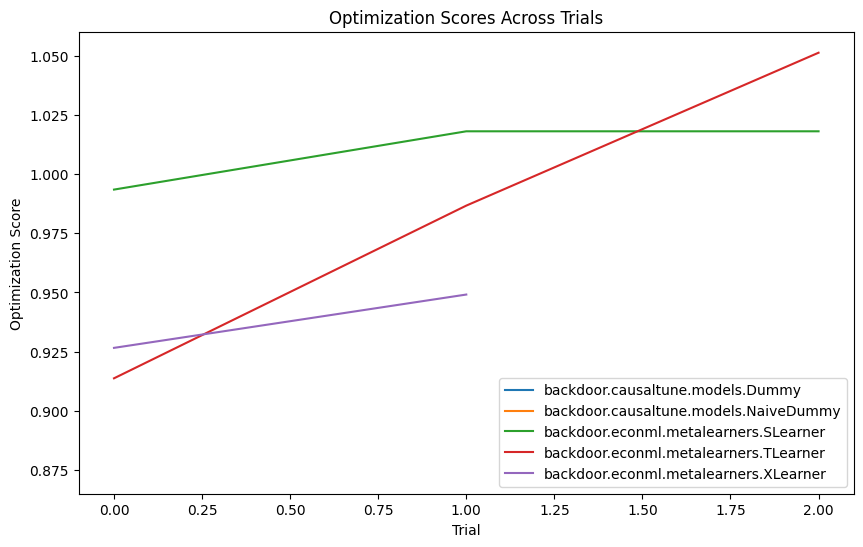

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
for est, scores in estimator_scores.items():
    plt.plot(range(len(scores)), [score['optimization_score'] for score in scores], label=est)
plt.xlabel('Trial')
plt.ylabel('Optimization Score')
plt.legend()
plt.title('Optimization Scores Across Trials')
plt.show()

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import colorsys
import textwrap
import matplotlib

# Define list of trials and metrics

metrics = ["frobenius_norm", "prob_erupt", "codec", "energy_distance", "psw_energy_distance"]
#metrics = ["frobenius_norm", "psw_energy_distance"]

# RCT
#trials = ['Linear_RCT']
trials = ['NonLinear_RCT']

# KC
#trials = ['Linear_KC'] 
#trials = ['NonLinear_KC']

# KCKP
#trials = ['Linear_KCKP'] 
#trials = ['NonLinear_KCKP']

# IV
#trials = ['Linear_IV'] 
#trials = ['NonLinear_IV']


#metrics = ["frobenius_norm", "codec", "energy_distance"]


### Define names for metrics and subplots to be displayed

# IV
# metric_names = ['Frobenius Norm', 'Energy Distance', 'CODEC']
# subplot_labels = ['(a)', '(b)', '(c)']

# RCT / KC
metric_names = ['Frobenius Norm', 'Probabilistic Erupt', 'Policy Risk', 'CODEC', 'Propensity Weighted Energy Distance']

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

# Coloring
colors = ([matplotlib.colors.CSS4_COLORS['black']] +
          list(matplotlib.colors.TABLEAU_COLORS) + [
              matplotlib.colors.CSS4_COLORS['lime'],
              matplotlib.colors.CSS4_COLORS['yellow'],
              matplotlib.colors.CSS4_COLORS['pink']
          ])

def scale_lightness(rgb, scale_l):
    # Convert RGB to HLS and adjust lightness
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s)


### Plot formatting

# Set columns
no_col = min(3, len(metrics))

# Dynamically set number of rows for subplots
if trials[0].startswith('iv') or len(metrics) < 4:
    no_rows = 1
else:
    no_rows = 2

fontsize = 9

backdoor.econml.metalearners.TLearner
backdoor.econml.metalearners.SLearner
backdoor.econml.metalearners.TLearner
backdoor.econml.metalearners.TLearner
backdoor.causaltune.models.Dummy


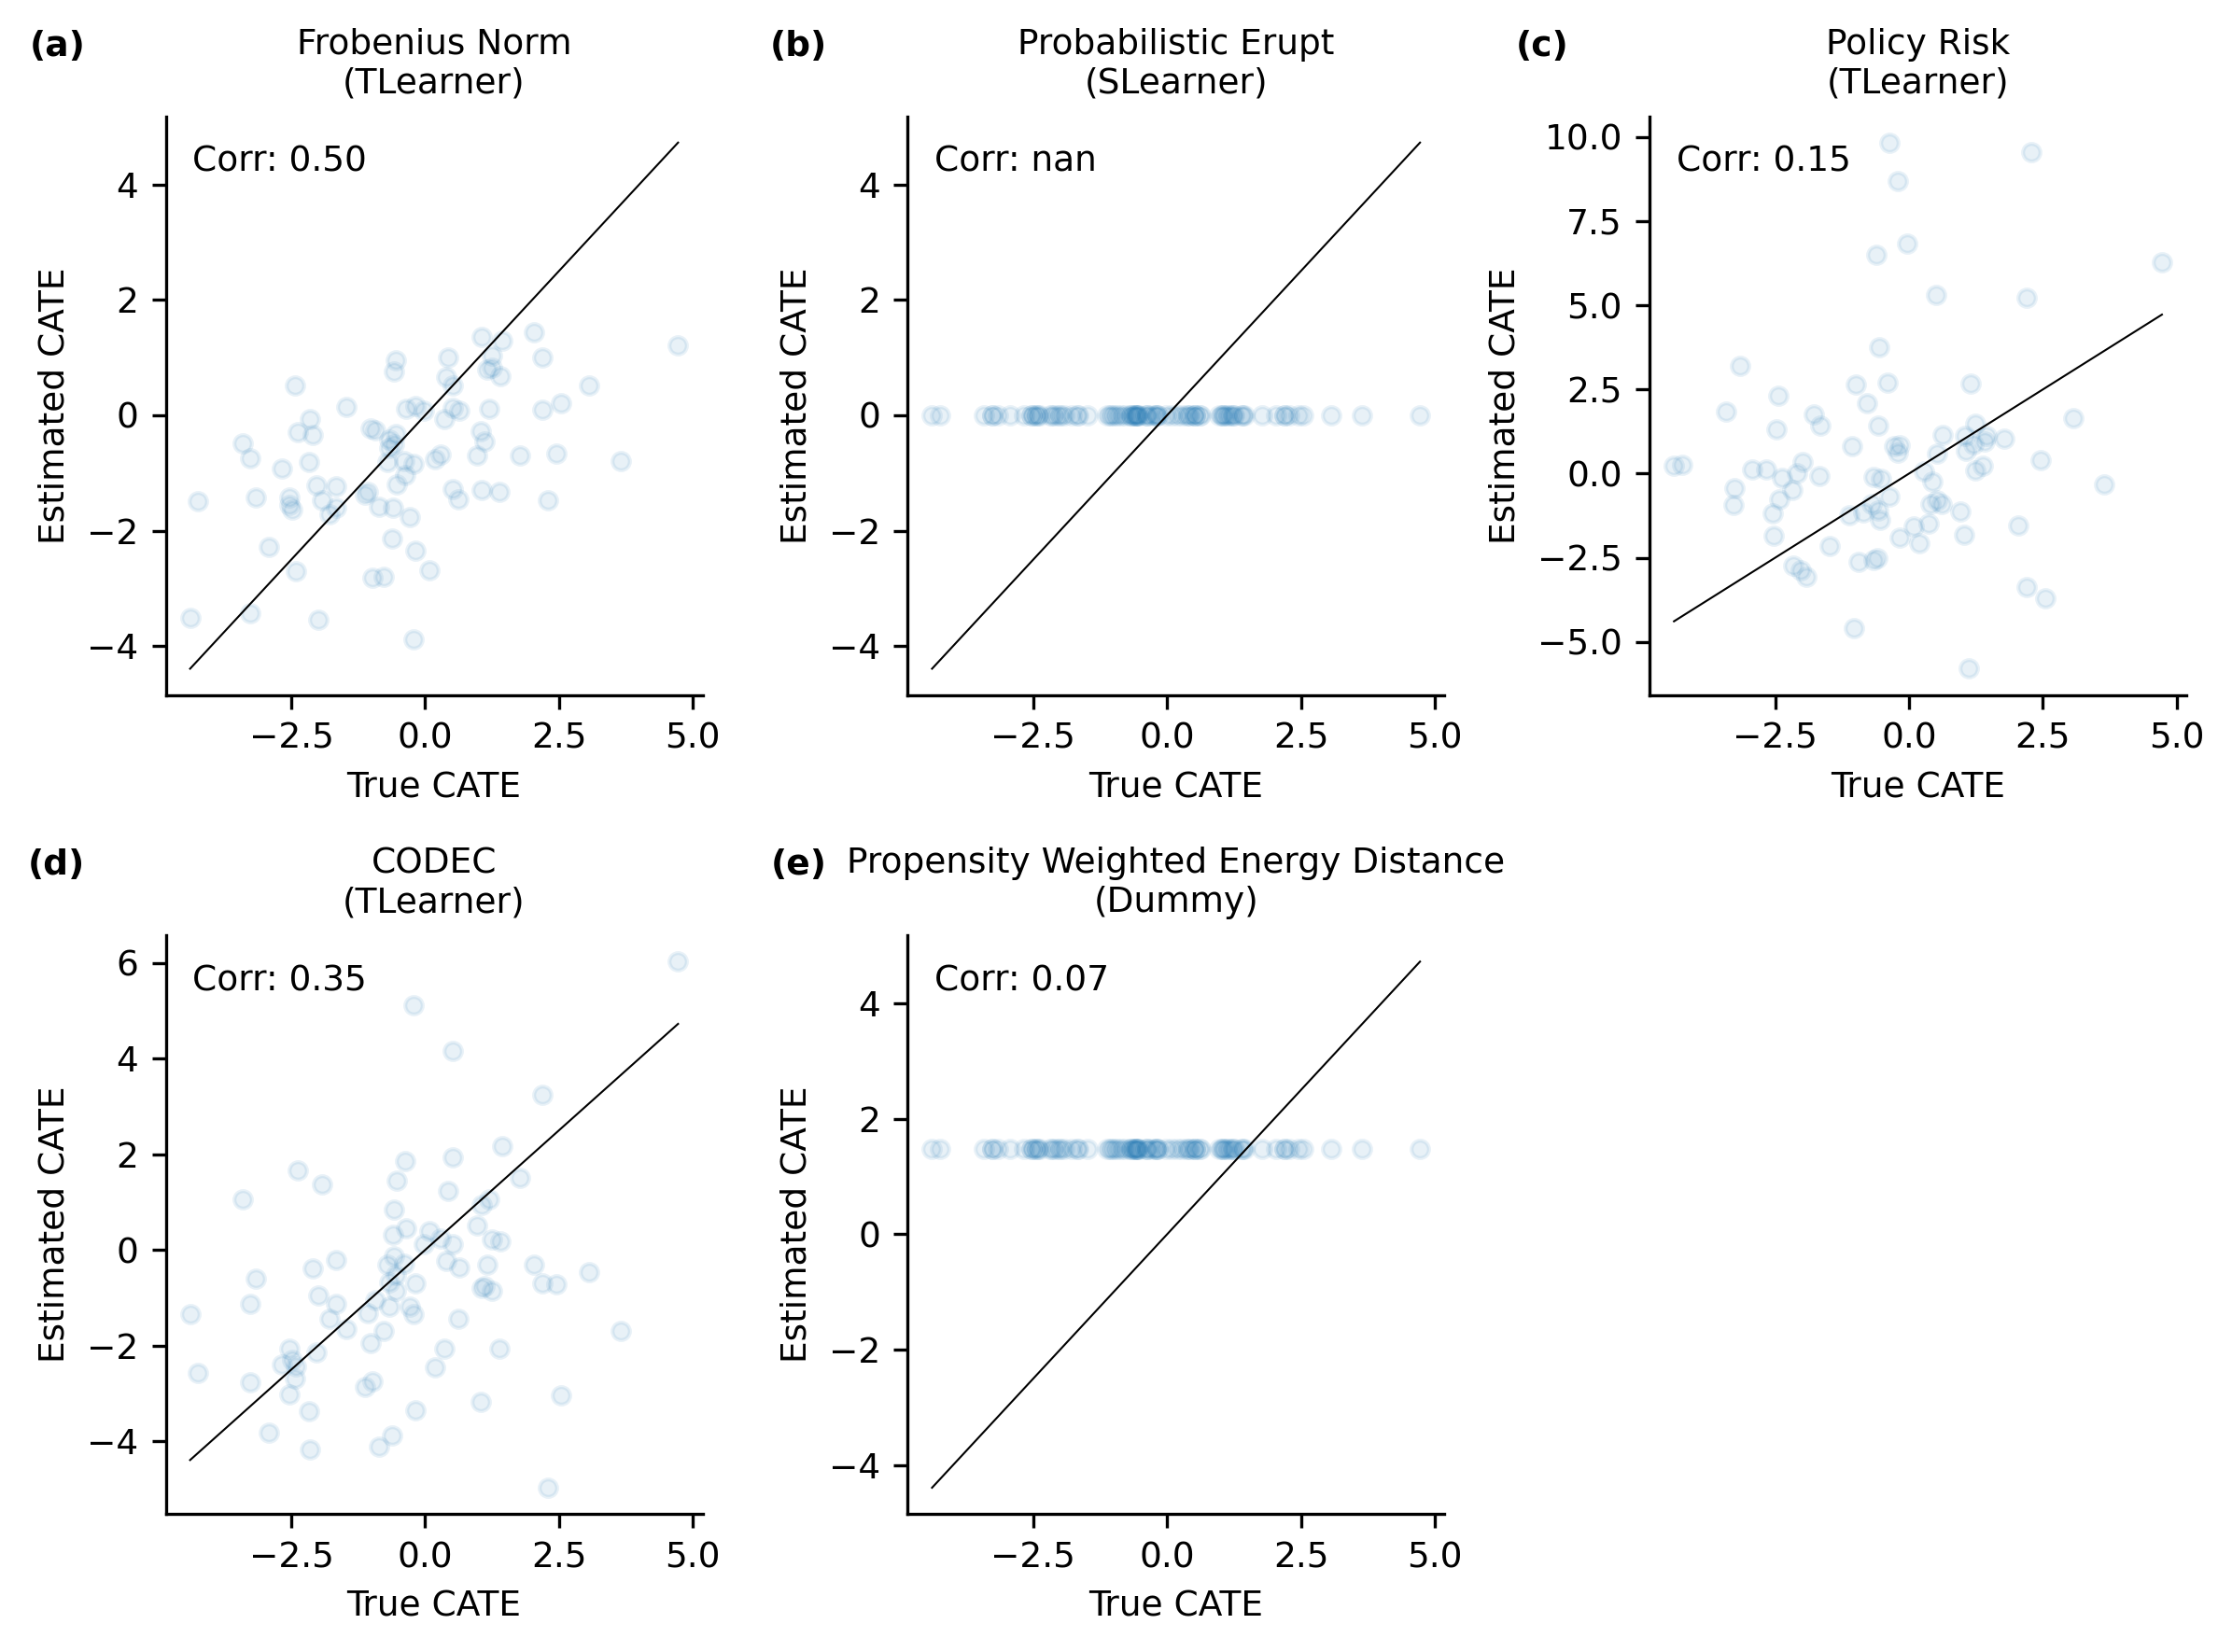

In [88]:
%matplotlib inline

fig, axs = plt.subplots(no_rows, no_col, figsize=(8, 3*no_rows), dpi=300)

# Ensure axs is a flat list even if there's only one row or column
if isinstance(axs, np.ndarray):
    axs = axs.flatten()
else:
    axs = [axs]  # In case there's only one subplot, wrap it in a list

# Plot true against estimated for best estimator
for i, (trial, metric) in enumerate([(t, m) for t in trials for m in metrics]):
    ax = axs[i]
    
    filename = f"{metric}_run_1_{trial}.pkl"

    with open(f"{out_dir}_{filename}", "rb") as f:
        results = pickle.load(f)

    # filename = f"{filename_out}_{metric}_run_1_{trial}.pkl"

    # with open(f"{out_dir}/{filename}", "rb") as f:
    #     results = pickle.load(f)
    
    best_estimator = results["best_estimator"]
    print(best_estimator)
    CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
    #print(results["scores_per_estimator"][best_estimator])
    CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]
    
    # Plot
    ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
    ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
    
    ax.set_xlabel("True CATE", fontsize=fontsize)
    ax.set_ylabel("Estimated CATE", fontsize=fontsize)
    
    ax.set_title(f"{metric_names[i]}\n({best_estimator.split('.')[-1]})", fontsize=fontsize)

    # Change the fontsize of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add correlation coefficient
    cate_gt_for_cor = list(CATE_gt)
    try:
        cate_est_for_cor = CATE_est[:, 0]
    except:
        cate_est_for_cor = CATE_est

    corr = np.corrcoef(cate_gt_for_cor, cate_est_for_cor)[0, 1]

    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=fontsize)

    # Add subplot label
    ax.text(-0.15, 1.15, subplot_labels[i], transform=ax.transAxes,
            fontsize=fontsize, fontweight='bold', va='top', ha='right')

# If there are extra axes (more subplots than metrics), remove the unused ones
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
#plt.savefig(f"{out_dir}/frob_rct_linear.pdf", format="pdf")
plt.show()


In [ ]:
for element in results["scores_per_estimator"]['backdoor.causaltune.models.Dummy']:
    print([element]==results["scores_per_estimator"]['backdoor.causaltune.models.Dummy'])
    print("*****************************************************")

#print((results["scores_per_estimator"]['backdoor.causaltune.models.Dummy']))
print(results.keys())

In [ ]:
print(results["best_estimator"])
print(results["best_score"])
print(results["scores_per_estimator"])

In [ ]:
print(results)#['backdoor.causaltune.models.TransformedOutcome'][0]['validation'])

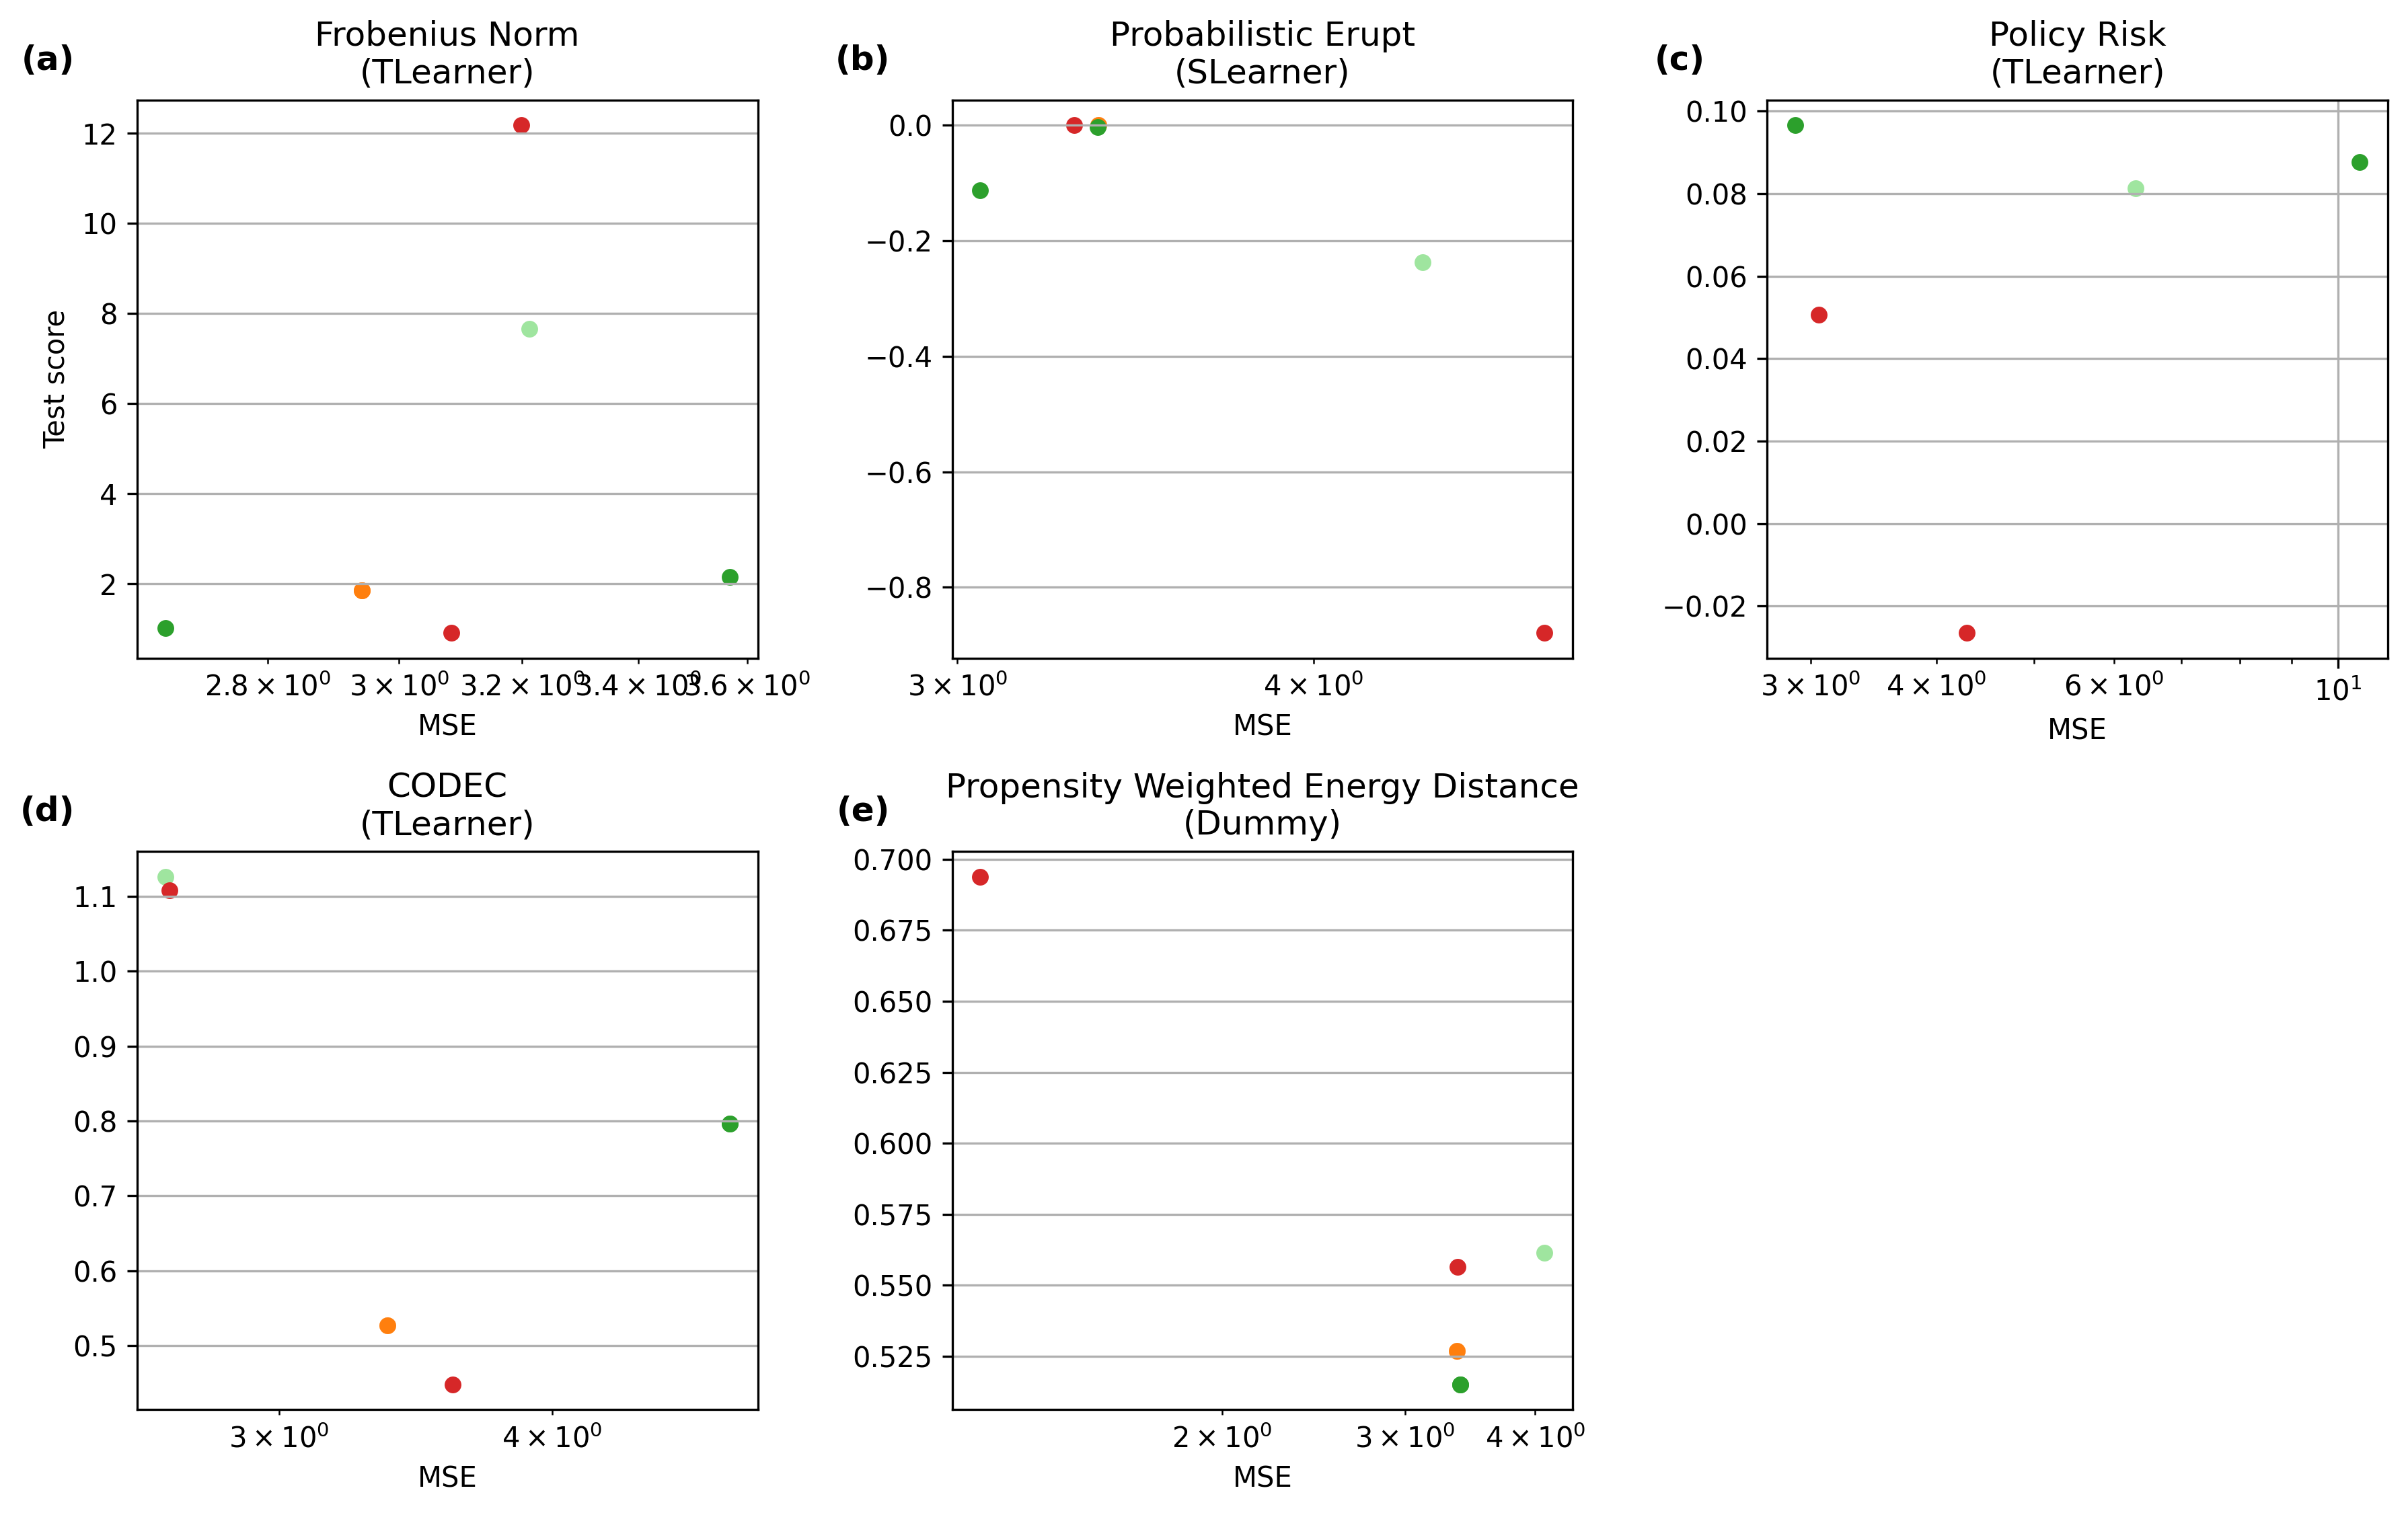

In [57]:
%matplotlib inline

fig, axs = plt.subplots(no_rows, no_col, figsize=(no_col * 4, no_rows * 4), dpi=300)

# Ensure axs is always a list (whether it's a 1D or 2D array)
if isinstance(axs, np.ndarray):
    axs = axs.flatten()
else:
    axs = [axs]

all_handles = []
all_labels = []

for row, trial in enumerate(trials):
    for col, metric in enumerate(metrics):
        ax = axs[col]
          
        filename = f"{metric}_run_1_{trial}.pkl"

        with open(f"{out_dir}_{filename}", "rb") as f:
            results = pickle.load(f)

        # filename = f"{filename_out}_{metric}_run_1_{trial}.pkl"
        # with open(f"{out_dir}/{filename}", "rb") as f:
        #     results = pickle.load(f)
        
        for idx, (est_name, scr) in enumerate(results["scores_per_estimator"].items()):
            if "Dummy" not in est_name and len(scr):
                # Plot intermediate runs
                if len(scr) > 1:
                    lightness = np.linspace(1, 2.8, len(scr))
                    col_rgb = matplotlib.colors.ColorConverter.to_rgb(colors[idx])
                    for i_run in range(1, len(scr)):
                        CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                        CATE_est = scr[i_run]["test"]["CATE_estimate"]
                        CATE_gt = np.array(CATE_gt).flatten()
                        CATE_est = np.array(CATE_est).flatten()
                        mse = np.mean((CATE_gt - CATE_est)**2)
                        score = scr[i_run]["test"][metric]  # Adjust metric access
                        ax.scatter(mse, score, color=scale_lightness(col_rgb, lightness[i_run-1]), 
                                   s=30, linewidths=0.5, label="nolegend")

                # Plot best estimator
                CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                CATE_est = scr[0]["test"]["CATE_estimate"]
                CATE_gt = np.array(CATE_gt).flatten()
                CATE_est = np.array(CATE_est).flatten()
                mse = np.mean((CATE_gt - CATE_est)**2)
                score = scr[0]["test"][metric]  # Adjust metric access
                scatter = ax.scatter(mse, score, color=colors[idx], s=30, linewidths=0.5)
                
                # Collect handles and labels for the overarching legend
                handle = scatter
                label = est_name.split(".")[-1]
                if label not in all_labels:
                    all_handles.append(handle)
                    all_labels.append(label)

        # Add bold subplot labels
        ax.text(-0.1, 1.1, subplot_labels[col], transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')
        
        if col == 0:
            ax.set_ylabel("Test score")
        ax.set_xlabel("MSE")
        best_estimator = results["best_estimator"]
        ax.set_title(f"{metric_names[col]}\n({best_estimator.split('.')[-1]})")
        ax.set_xscale("log")
        ax.grid(True)

# Remove unused subplots if there are any
for j in range(len(metrics), len(axs)):
    fig.delaxes(axs[j])

# Add legend in the last (empty) subplot, if applicable
if len(all_handles) > 0 and len(all_labels) > 0:  # Ensure valid handles and labels
    last_ax_index = len(axs) - 1  # Get the last subplot index
    if not ax.has_data():  # Ensure the last subplot is free
        axs[last_ax_index].legend(all_handles, all_labels, loc='center', frameon=False)
        axs[last_ax_index].axis('off')  # Hide the axis of the legend subplot

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{out_dir}/frob_test_ranking_rct_linear.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from dowhy.causal_estimator import CausalEstimate
from causaltune.utils import psw_joint_weights

def frobenius_norm_score(
    self,
    estimate: CausalEstimate,
    df: pd.DataFrame,
    sd_threshold: float = 1e-2,
) -> float:
    """
    Calculate propensity score weighted Frobenius norm-based score between treated and controls.
    
    Args:
        estimate (CausalEstimate): causal estimate to evaluate
        df (pandas.DataFrame): input dataframe
        sd_threshold (float): threshold for standard deviation of CATE estimates
    
    Returns:
        float: Propensity-score weighted Frobenius norm-based score, or np.inf if calculation is not possible
    """
    # Attempt to get CATE estimates, handling potential AttributeErrors
    try:
        cate_estimates = estimate.estimator.effect(df)
    except AttributeError:
        try:
            cate_estimates = estimate.estimator.effect_tt(df)
        except AttributeError:
            return np.inf  # Return inf if neither method is available

    # Check if CATE estimates are consistently constant (below threshold)
    if np.std(cate_estimates) <= sd_threshold:
        return np.inf  # Return inf for constant CATE estimates

    # Prepare data for treated and control groups
    Y0X, treatment_name, split_test_by = self._Y0_X_potential_outcomes(estimate, df)
    Y0X_1 = Y0X[Y0X[split_test_by] == 1]  # Treated group
    Y0X_0 = Y0X[Y0X[split_test_by] == 0]  # Control group

    # Check if either group is empty
    if len(Y0X_1) == 0 or len(Y0X_0) == 0:
        return np.inf  # Return inf if either group is empty

    # Select columns for analysis
    select_cols = estimate.estimator._effect_modifier_names + ["yhat"]

    # Calculate propensity scores
    propensitymodel = self.psw_estimator.estimator.propensity_model
    YX_1_all_psw = propensitymodel.predict_proba(
        Y0X_1[
            self.causal_model.get_effect_modifiers()
            + self.causal_model.get_common_causes()
        ]
    )
    treatment_series = Y0X_1[treatment_name]
    YX_1_psw = np.zeros(YX_1_all_psw.shape[0])
    for i in treatment_series.unique():
        YX_1_psw[treatment_series == i] = YX_1_all_psw[:, i][treatment_series == i]

    YX_0_psw = propensitymodel.predict_proba(
        Y0X_0[
            self.causal_model.get_effect_modifiers()
            + self.causal_model.get_common_causes()
        ]
    )[:, 0]

    # Calculate pairwise differences
    differences_xy = Y0X_1[select_cols].values[:, np.newaxis, :] - Y0X_0[select_cols].values[np.newaxis, :, :]
    
    # Calculate joint weights
    xy_psw = psw_joint_weights(YX_1_psw, YX_0_psw)
    xy_mean_weights = np.mean(xy_psw)
    
    # Weight the differences
    weighted_differences_xy = np.reciprocal(xy_mean_weights) * np.multiply(
        xy_psw[:, :, np.newaxis],
        differences_xy
    )
    
    # Compute Frobenius norm
    frobenius_norm = np.linalg.norm(weighted_differences_xy, ord='fro')
    
    # Normalize
    n_1, n_0 = len(Y0X_1), len(Y0X_0)
    p = differences_xy.shape[-1]  # number of features
    normalized_score = frobenius_norm / np.sqrt(n_1 * n_0 * p)
    
    return normalized_score if np.isfinite(normalized_score) else np.inf

In [ ]:


def run_experiment(cd, metric, run_number):
    cd_i = copy.deepcopy(cd)
    train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    cd_i.data = train_df
    
    ct = CausalTune(
        metric=metric,
        metrics_to_report=[metric],
        verbose=1,
        components_verbose=1,
        components_time_budget=components_time_budget,
        estimator_list=estimator_list,
        num_samples=num_samples,
        store_all_estimators=True,
        outcome_model="auto"
    )
    
    ct.fit(
        data=cd_i,
        treatment="treatment",
        outcome="outcome",
    )
    
    datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
    estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
    
    for trial in ct.results.trials:
        estimator_name = trial.last_result["estimator_name"]
        if trial.last_result["estimator"]:
            estimator = trial.last_result["estimator"]
            scores = {}
            for ds_name, df in datasets.items():
                scores[ds_name] = {}
                est_scores = ct.scorer.make_scores(
                    estimator,
                    df,
                    metrics_to_report=ct.metrics_to_report,
                )
                scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                scores[ds_name][metric] = est_scores[metric]
            estimator_scores[estimator_name].append(scores)
    
    for k in estimator_scores.keys():
        estimator_scores[k] = sorted(
            estimator_scores[k],
            key=lambda x: x["validation"][metric],
            reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec"] else True,
        )
    
    return {
        "best_estimator": ct.best_estimator,
        "best_config": ct.best_config,
        "best_score": ct.best_score,
        "optimised_metric": metric,
        "scores_per_estimator": estimator_scores,
    }

for dataset_name, cd in data_sets.items():
    for metric in metrics:
        all_runs_results = []
        
        for i_run in range(1, n_runs + 1):
            run_results = run_experiment(cd, metric, i_run)
            all_runs_results.append(run_results)
        
        # Aggregate results across runs
        aggregated_results = {
            "best_estimator": [],
            "best_score": [],
            "scores_per_estimator": {est: [] for est in estimator_list if "NewDummy" not in est}
        }
        
        for run_result in all_runs_results:
            aggregated_results["best_estimator"].append(run_result["best_estimator"])
            aggregated_results["best_score"].append(run_result["best_score"])
            
            for est, scores in run_result["scores_per_estimator"].items():
                if scores:  # Check if the list is not empty
                    aggregated_results["scores_per_estimator"][est].append(scores[0])  # Append the best score
        
        # Select the best result across runs
        best_run_index = np.argmax(aggregated_results["best_score"]) if metric not in ["energy_distance", "psw_energy_distance", "codec"] else np.argmin(aggregated_results["best_score"])
        
        best_result = {
            "best_estimator": aggregated_results["best_estimator"][best_run_index],
            "best_config": all_runs_results[best_run_index]["best_config"],
            "best_score": aggregated_results["best_score"][best_run_index],
            "optimised_metric": metric,
            "scores_per_estimator": {est: scores[best_run_index] for est, scores in aggregated_results["scores_per_estimator"].items() if scores},
            "all_runs_results": all_runs_results  # Store all run results for potential further analysis
        }
        
        with open(f"{out_dir}{filename_out}_{metric}_best_of_{n_runs}_runs_{dataset_name}.pkl", "wb") as f:
            pickle.dump(best_result, f)

In [ ]:
def find_best_estimator(results, metric='frobenius_norm', lower_is_better=True):
    best_score = float('inf') if lower_is_better else float('-inf')
    best_estimator = None
    best_set = None

    for estimator, scores_list in results['scores_per_estimator'].items():
        for score_dict in scores_list:
            for set_name in ['validation']:
                if set_name in score_dict and metric in score_dict[set_name]:
                    score = score_dict[set_name][metric]
                    if isinstance(score, (int, float)):
                        if (lower_is_better and score < best_score) or (not lower_is_better and score > best_score):
                            best_score = score
                            best_estimator = estimator
                            best_set = set_name

    return best_estimator, best_score, best_set

# Usage
best_estimator, best_score, best_set = find_best_estimator(results, metric='frobenius_norm')
print(f"Best estimator according to scores_per_estimator: {best_estimator}")
print(f"Best score: {best_score}")
print(f"Set with best score: {best_set}")

# Compare with the reported best estimator
print(f"\nReported best estimator: {results['best_estimator']}")
print(f"Reported best score: {results['best_score']}")

# Check if they match
if best_estimator == results['best_estimator']:
    print("\nThe best estimators match!")
else:
    print("\nThe best estimators do not match.")
    print("This suggests a discrepancy in how the best estimator is being selected.")